In [38]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import get_context
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import json
import pprint

workspace_root = Path.cwd().parent.parent

src_path = workspace_root / "data"
if not src_path.exists():
    raise FileNotFoundError(f"Local data folder not found: {src_path}")

data_files = list(src_path.rglob("00*"))

data_files = [
    path for path in data_files
    if path.is_dir()
    and (path / "foci_mask.npy").exists()
    and (path / "labels.json").exists()
 ]
print(len(data_files))

676


In [ ]:
sample = data_files[0]
with open(sample / 'labels.json') as f:
    lbl = json.load(f)
print(list(lbl.keys()))
pprint.pprint({k: (type(v).__name__, len(v)) for k,v in lbl.items()})
print(lbl.get('points_53BP1', [])[:5])

['points_53BP1', 'points_gH2AX']
{'points_53BP1': ('list', 153), 'points_gH2AX': ('list', 339)}
[[227, 466, 17], [234, 440, 17], [265, 479, 18], [213, 438, 20], [289, 458, 19]]


# Loading

labels are in shape 
xyz (1392 × 1040 × 50 px)

In [3]:
FOV_X_UM = 90.0
FOV_Y_UM = 67.2
FOV_Z_UM = 15.0

def get_voxel_volume_um3(mask_shape_zyx):
    z_px, y_px, x_px = mask_shape_zyx
    sx_um = FOV_X_UM / float(x_px)
    sy_um = FOV_Y_UM / float(y_px)
    sz_um = FOV_Z_UM / float(z_px)
    return sx_um * sy_um * sz_um

In [9]:
def process_one_data_selected(data_selected):
    rows_local = []
    nuclei_rows_local = []
    outside_points_info = []  # To store information about points falling outside nuclei
    image_info = "/".join(str(data_selected).split("/")[-3:])

    labels_path = data_selected / 'labels.json'
    if not labels_path.exists():
        return rows_local, nuclei_rows_local, outside_points_info

    with open(labels_path, 'r') as f:
        lbls = json.load(f)

    nuclei_path = data_selected / 'nuclei_mask.npy'
    if not nuclei_path.exists():
        return rows_local, nuclei_rows_local, outside_points_info

    nuclei_mask = np.load(nuclei_path, mmap_mode='r')
    nuclei_zxy = nuclei_mask.astype(np.int32, copy=False)

    nucleus_labels = np.unique(nuclei_zxy)
    nucleus_labels = nucleus_labels[nucleus_labels > 0]
    nuclei_rows_local = [
        {"image_info": image_info, "nucleus_label": int(nucleus_label)}
        for nucleus_label in nucleus_labels
    ]

    # labels.json uses 1-based [X,Y,Z] coordinates in original label image shape
    LABELS_SHAPE_XYZ = np.array([1392, 1040, 50], dtype=float)  # X, Y, Z
    # nuclei_zxy has shape (Z, X, Y) in numpy ordering
    nuc_shape = nuclei_zxy.shape
    NUCLEI_SHAPE_XYZ = np.array([nuc_shape[1], nuc_shape[2], nuc_shape[0]], dtype=float)  # Adjusted for ZXY
    scale = NUCLEI_SHAPE_XYZ / LABELS_SHAPE_XYZ

    channel_map = {
        'points_gH2AX': 'gH2AX',
        'points_53BP1': '53BP1',
    }

    for key, channel_name in channel_map.items():
        pts = np.array(lbls.get(key, []), dtype=float)
        if pts.size == 0:
            continue
        # convert 1-based [X,Y,Z] -> 0-based
        pts0 = pts - 1.0
        xs = pts0[:, 0]
        ys = pts0[:, 1]
        zs = pts0[:, 2]

        # map to nuclei mask coordinate space
        new_x = np.round(xs * scale[0]).astype(np.int64)
        new_y = np.round(ys * scale[1]).astype(np.int64)
        new_z = np.round(zs * scale[2]).astype(np.int64)

        # clip to valid range
        new_x = np.clip(new_x, 0, int(NUCLEI_SHAPE_XYZ[0] - 1))
        new_y = np.clip(new_y, 0, int(NUCLEI_SHAPE_XYZ[1] - 1))
        new_z = np.clip(new_z, 0, int(NUCLEI_SHAPE_XYZ[2] - 1))

        # lookup nucleus id for each point
        nucleus_ids = nuclei_zxy[new_z, new_x, new_y]  # Adjusted for ZXY

        # count points that fall outside any nucleus
        outside_count = int(np.sum(nucleus_ids <= 0))
        outside_points_info.append({
            "image_info": image_info,
            "channel": channel_name,
            "outside_count": outside_count,
            "total_points": len(nucleus_ids),
            "percentage_outside": (outside_count / len(nucleus_ids)) * 100 if len(nucleus_ids) > 0 else 0.0
        })

        # append one row per point assigned to a nucleus (so downstream grouping by count works)
        foci_id = 0
        for nid in nucleus_ids:
            if nid <= 0:
                continue
            foci_id += 1
            rows_local.append({
                'image_info': image_info,
                'channel': channel_name,
                'foci_label': int(foci_id),
                'foci_size': 1,
                'nucleus_label': int(nid),
            })

    return rows_local, nuclei_rows_local, outside_points_info

In [10]:
paths_to_run = data_files[:100]
max_workers = min(os.cpu_count(), 8)

In [11]:
rows = []
nuclei_rows = []
outside_info = []
ctx = get_context("fork")
with ProcessPoolExecutor(max_workers=max_workers, mp_context=ctx) as executor:
    for rows_local, nuclei_rows_local, outside_points_info in tqdm(
        executor.map(process_one_data_selected, paths_to_run),
        total=len(paths_to_run),
    ):
        rows.extend(rows_local)
        nuclei_rows.extend(nuclei_rows_local)
        outside_info.extend(outside_points_info)

# Convert outside points info to a DataFrame for analysis
outside_info_df = pd.DataFrame(outside_info)
outside_info_df.to_csv("outside_points_info.csv", index=False)

# Example: Analyze the percentage of points falling outside
print(outside_info_df.groupby("channel")["percentage_outside"].describe())

100%|██████████| 100/100 [00:03<00:00, 31.75it/s]


         count       mean        std        min        25%        50%  \
channel                                                                 
53BP1    100.0  79.484210  13.448771  36.607143  71.461590  81.441215   
gH2AX    100.0  77.948486  15.185895  31.640625  70.956653  80.683749   

               75%    max  
channel                    
53BP1    89.157365  100.0  
gH2AX    89.041767  100.0  


In [12]:
outside_info_df

,image_info,channel,outside_count,total_points,percentage_outside
0,NHDF_8h PI/IR 4Gy_8h PI/0003,gH2AX,284,339,83.775811
1,NHDF_8h PI/IR 4Gy_8h PI/0003,53BP1,123,153,80.392157
2,NHDF_8h PI/IR 4Gy_8h PI/0004,gH2AX,247,461,53.579176
3,NHDF_8h PI/IR 4Gy_8h PI/0004,53BP1,176,315,55.873016
4,NHDF_8h PI/IR 4Gy_8h PI/0032,gH2AX,237,445,53.258427
...,...,...,...,...,...
195,NHDF_8h PI/IR 1Gy_8h PI/0003,53BP1,24,35,68.571429
196,NHDF_8h PI/IR 1Gy_8h PI/0004,gH2AX,590,808,73.019802
197,NHDF_8h PI/IR 1Gy_8h PI/0004,53BP1,49,53,92.452830
198,NHDF_8h PI/IR 1Gy_8h PI/0005,gH2AX,712,712,100.000000


In [12]:
labels_df = (
    pd.DataFrame(rows)
    .sort_values(["image_info", "channel", "foci_label"])
    .reset_index(drop=True)
)
labels_df.to_csv("labels.csv", index=False)

nuclei_rows_df = (
    pd.DataFrame(nuclei_rows, columns=["image_info", "nucleus_label"])
    .drop_duplicates(["image_info", "nucleus_label"])
    .sort_values(["image_info", "nucleus_label"])
    .reset_index(drop=True)
)
nuclei_rows_df.to_csv("nuclei_labels.csv", index=False)

# Analysis

In [39]:
labels_df = pd.read_csv("labels.csv")
nuclei_rows_df = pd.read_csv("nuclei_labels.csv")

In [40]:
labels_df.head()

,image_info,channel,foci_label,foci_size,nucleus_label
0,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,1,1,1
1,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,2,1,1
2,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,3,1,1
3,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,4,1,1
4,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,5,1,1


In [41]:
nuclei_rows_df.head()

,image_info,nucleus_label
0,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1
1,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",2
2,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",3
3,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",4
4,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",5


In [42]:
nuclei_labels_df = (
    labels_df
    .groupby(["image_info", "channel", "nucleus_label"], as_index=False)
    .agg(
        n_foci=("foci_label", "count"),
    )
    .sort_values(["image_info", "channel", "nucleus_label"])
    .reset_index(drop=True)
)
# Transpose the table so that 'channel' becomes a column
nuclei_labels_df_pivot = (
    nuclei_labels_df
    .pivot(index=["image_info", "nucleus_label"], columns="channel", values="n_foci")
    .reset_index()
)

# Rename columns for clarity (optional)
nuclei_labels_df_pivot.columns.name = None  # Remove the multi-index column name
nuclei_labels_df_pivot = nuclei_labels_df_pivot.rename_axis(None, axis=1)  # Remove index name

# Fill NaN values with 0 (if needed)
nuclei_labels_df_pivot = nuclei_labels_df_pivot.fillna(0)

# Display the transposed table
nuclei_labels_df_pivot.head()

,image_info,nucleus_label,53BP1,gH2AX
0,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1,21.0,17.0
1,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",2,13.0,20.0
2,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",3,4.0,33.0
3,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",4,9.0,151.0
4,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",5,25.0,40.0


In [43]:
nuclei_foci = (
    nuclei_rows_df
    .merge(nuclei_labels_df_pivot, on=["image_info", "nucleus_label"], how="left")
    .sort_values(["image_info", "nucleus_label"])
    .reset_index(drop=True)
)

In [44]:
nuclei_foci_long = (
    nuclei_foci.melt(
        id_vars=["image_info", "nucleus_label"],  # Columns to keep
        value_vars=["53BP1", "gH2AX"],           # Columns to unpivot
        var_name="channel",                      # Name of the new column for the variable names
        value_name="n_foci"                      # Name of the new column for the values
    )
    .sort_values(["image_info", "nucleus_label", "channel"])  # Optional: sort the DataFrame
    .reset_index(drop=True)                                   # Reset the index
)

# Display the transformed DataFrame
nuclei_foci_long.head()

,image_info,nucleus_label,channel,n_foci
0,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1,53BP1,21.0
1,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1,gH2AX,17.0
2,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",2,53BP1,13.0
3,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",2,gH2AX,20.0
4,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",3,53BP1,4.0


In [45]:
def add_experiment_metadata(input_df):
    df = input_df.copy()

    s = (
        df["image_info"]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

    parts = s.str.split("/", expand=True)
    group_part = parts[0].fillna("")
    dose_part = parts[1].fillna("")

    df["cell_line"] = group_part.str.extract(r"^([A-Za-z0-9-]+)", expand=False)

    dose_clean = (
        dose_part
        .str.replace("IR_", "", regex=False)
        .str.replace("IR ", "", regex=False)
        .str.extract(r"([0-9]+(?:\.[0-9]+)?)", expand=False)
    )
    df["dose_gy"] = pd.to_numeric(dose_clean, errors="coerce")
    df["dose"] = df["dose_gy"].map(lambda v: f"{v:g} Gy" if pd.notna(v) else np.nan)

    time_clean = (
        group_part
        .str.lower()
        .str.extract(r"(30\s*min|30min|8h)", expand=False)
        .str.replace(" ", "", regex=False)
    )
    df["time_raw"] = time_clean
    df["timepoint"] = df["time_raw"].map({
        "30min": "Early (30 min)",
        "8h": "Late (8h)",
    })

    return df

def validate_df_for_analysis(df, df_name):
    print(f"\n=== Validation: {df_name} ===")

    null_counts = df.isna().sum()
    null_counts = null_counts[null_counts > 0].sort_values(ascending=False)
    if null_counts.empty:
        print("Null values: none")
    else:
        print("Null values (only columns with nulls):")
        display(null_counts.to_frame(name="null_count"))

    for col in ["timepoint", "dose", "cell_line"]:
        if col in df.columns:
            unique_vals = sorted(df[col].dropna().astype(str).unique().tolist())
            print(f"Unique values in {col} ({len(unique_vals)}): {unique_vals}")

    def check_positive(col_name):
        if col_name not in df.columns:
            return
        numeric_col = pd.to_numeric(df[col_name], errors="coerce")
        n_null = int(numeric_col.isna().sum())
        n_non_positive = int((numeric_col <= 0).sum())
        is_positive = (n_null == 0) and (n_non_positive == 0)
        print(
            f"{col_name}: positive-only={is_positive} | null_or_non_numeric={n_null} | <=0={n_non_positive}"
        )

labels_df = add_experiment_metadata(labels_df)
nuclei_labels_df = add_experiment_metadata(nuclei_labels_df)

validate_df_for_analysis(labels_df, "labels_df")
validate_df_for_analysis(nuclei_labels_df, "nuclei_labels_df")

display(labels_df.head())
display(nuclei_labels_df.head())


=== Validation: labels_df ===
Null values: none
Unique values in timepoint (2): ['Early (30 min)', 'Late (8h)']
Unique values in dose (5): ['0.5 Gy', '1 Gy', '2 Gy', '4 Gy', '8 Gy']
Unique values in cell_line (2): ['NHDF', 'U87']

=== Validation: nuclei_labels_df ===
Null values: none
Unique values in timepoint (2): ['Early (30 min)', 'Late (8h)']
Unique values in dose (5): ['0.5 Gy', '1 Gy', '2 Gy', '4 Gy', '8 Gy']
Unique values in cell_line (2): ['NHDF', 'U87']


,image_info,channel,foci_label,foci_size,nucleus_label,cell_line,dose_gy,dose,time_raw,timepoint
0,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,1,1,1,NHDF,0.5,0.5 Gy,30min,Early (30 min)
1,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,2,1,1,NHDF,0.5,0.5 Gy,30min,Early (30 min)
2,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,3,1,1,NHDF,0.5,0.5 Gy,30min,Early (30 min)
3,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,4,1,1,NHDF,0.5,0.5 Gy,30min,Early (30 min)
4,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,5,1,1,NHDF,0.5,0.5 Gy,30min,Early (30 min)


,image_info,channel,nucleus_label,n_foci,cell_line,dose_gy,dose,time_raw,timepoint
0,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,1,21,NHDF,0.5,0.5 Gy,30min,Early (30 min)
1,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,2,13,NHDF,0.5,0.5 Gy,30min,Early (30 min)
2,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,3,4,NHDF,0.5,0.5 Gy,30min,Early (30 min)
3,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,4,9,NHDF,0.5,0.5 Gy,30min,Early (30 min)
4,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,5,25,NHDF,0.5,0.5 Gy,30min,Early (30 min)


Unique cell lines: ['NHDF', 'U87']
Unique timepoints: ['Early (30 min)', 'Late (8h)']

Cell line: NHDF | Timepoint: Early (30 min)


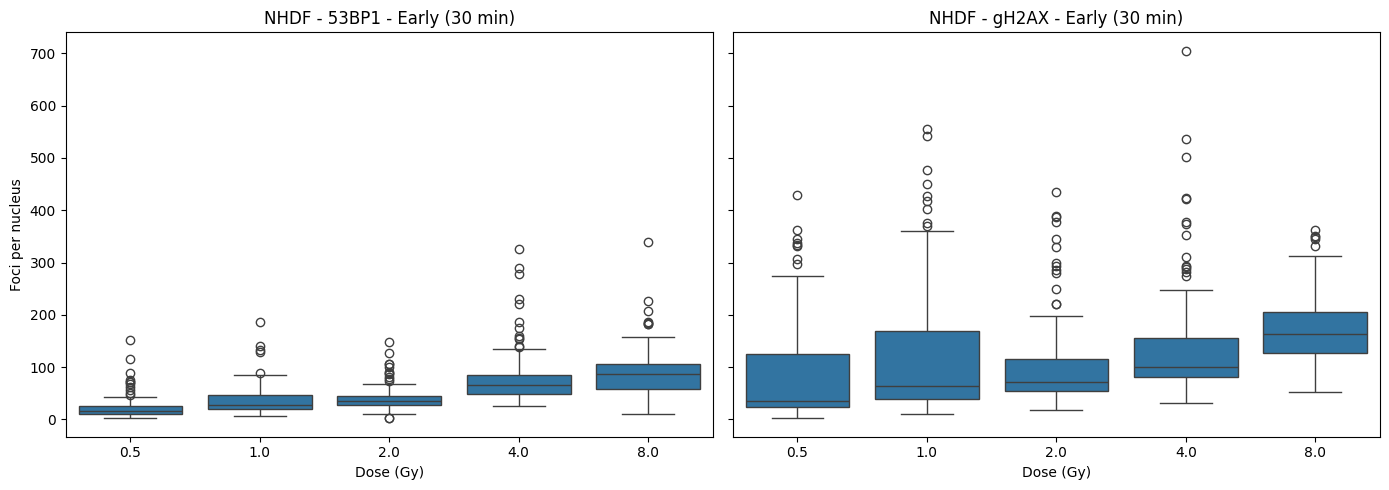


Cell line: NHDF | Timepoint: Late (8h)


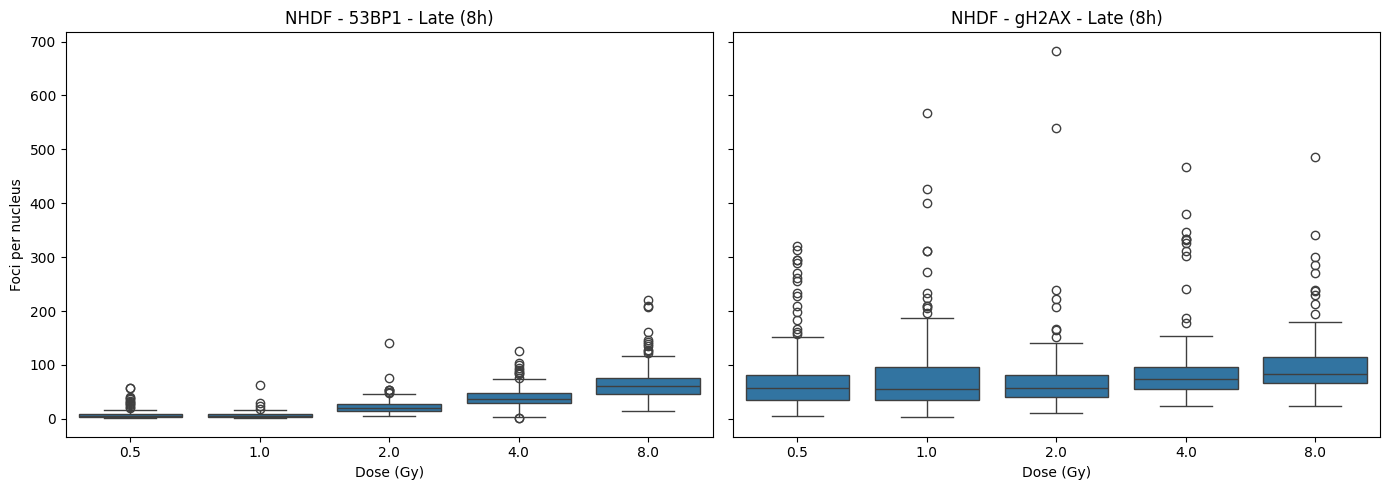


Cell line: U87 | Timepoint: Early (30 min)


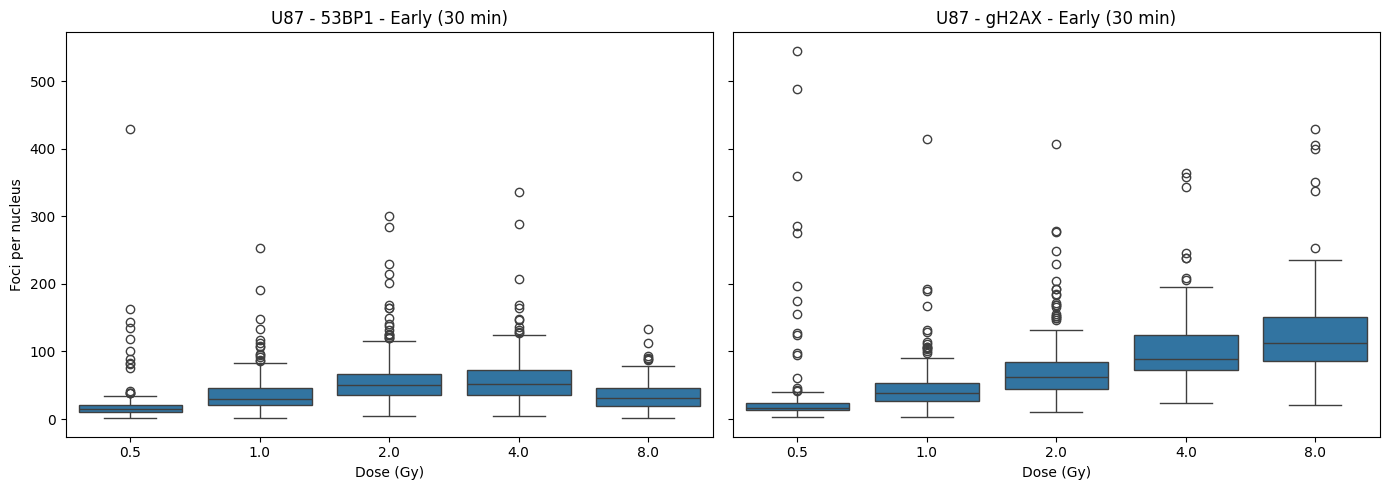


Cell line: U87 | Timepoint: Late (8h)


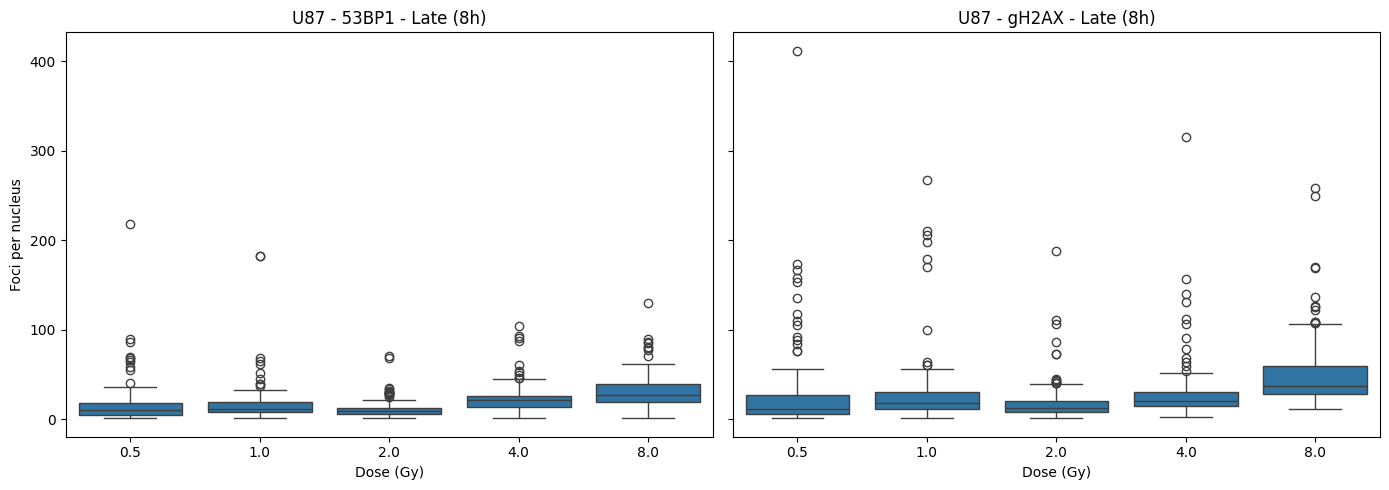

In [49]:


def plot_foci_vs_dose(input_df, cell_line, timepoint):
    df = input_df[(input_df["cell_line"] == cell_line) & (input_df["timepoint"] == timepoint)].copy()

    if df.empty:
        print(f"No data for cell line={cell_line}, timepoint={timepoint}")
        return

    dose_order = sorted(df["dose_gy"].dropna().unique())
    preferred_channel_order = ["53BP1", "gH2AX", "colocalized"]
    channel_order = [ch for ch in preferred_channel_order if ch in df["channel"].unique()]

    n_channels = len(channel_order)
    fig, axes = plt.subplots(1, n_channels, figsize=(7 * n_channels, 5), sharey=True)
    if n_channels == 1:
        axes = [axes]

    for c, ch in enumerate(channel_order):
        ax = axes[c]
        dsub = df[df["channel"] == ch]

        if dsub.empty:
            ax.set_title(f"{cell_line} - {ch} - {timepoint}")
            ax.set_xlabel("Dose (Gy)")
            ax.set_ylabel("Foci per nucleus")
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            continue

        sns.boxplot(
            data=dsub,
            x="dose_gy",
            y="n_foci",
            order=dose_order,
            ax=ax,
        )
        ax.set_title(f"{cell_line} - {ch} - {timepoint}")
        ax.set_xlabel("Dose (Gy)")
        ax.set_ylabel("Foci per nucleus")

    plt.tight_layout()
    plt.show()

# Iterate over Cartesian product of unique cell lines and unique timepoints
unique_cell_lines = sorted(nuclei_labels_df["cell_line"].dropna().unique())
unique_timepoints = sorted(nuclei_labels_df["timepoint"].dropna().unique())
print("Unique cell lines:", unique_cell_lines)
print("Unique timepoints:", unique_timepoints)

for selected_cell_line, tp in product(unique_cell_lines, unique_timepoints):
    print(f"\nCell line: {selected_cell_line} | Timepoint: {tp}")
    plot_foci_vs_dose(nuclei_labels_df, selected_cell_line, tp)